# Livrable 1 : Notebook de Nettoyage des données

Ce premier livrable du projet 2 : Concevez une application au service de la santé publique, contient une version de notebook des données cleané accompagné d'une explication de la démarche.

Dans ce Notebook, on va chercher à estimer la qualité des données en notre possession.

# Idée d'application

Mise en place d'un indicateur nutriscore pour un utilisateur qui n’aurait que quelques informations élémentaires nutritionnelles sur le produit. Avec seulement des données composées de 5-10 Variables l'utilisateur pourrait voir une première ébauche de nutriscore. (jeu de données réduit)

On souhaite analyser les données que nous avons, voir lesquelles des features a garder dans notre jeu de données réduit afin de mettre en place le nutriscore estimés globalement.

# Import des bibliotèques

In [2]:
import dask.dataframe as dd
import numpy as np
import pandas as pd
import re
import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer,KNNImputer

# Import des données

Tout d'abord on importe les données que nous allons traiter et utiliser lors de ce projet.

In [5]:
## Le path contient le nom du fichier des données provenenant de L'agence "Santé publique France"
path = "fr.openfoodfacts.org.products.csv" 

## Import des données CSV
data = pd.read_csv(path, decimal = ',', sep='\t', low_memory=False)

In [6]:
## Visualisation des données brutes
pd.set_option('display.max_columns', None)
data.head(2)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,NaN,28 g (1 ONZ),NaN,0.0,[ bananas -> en:bananas ]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(24), object(138)
memory usage: 396.5+ MB


# Milestone 1 : Nettoyage – Filtrage des features et produits

Dans cette première milestone nous allons faire faire un état des lieux des données qu'on a. En d'autres termes : 

- Afficher le taux de remplissage des composantes
- Evaluer les valeurs manquantes 
- Selectionner les features qui nous semblent les plus cohérentes
- et d'identifier si il y a des features qu'on éliminer des le début.

On va tout d'abord lister les features pour les analyser.

In [9]:
###Liste des features
features = list(data.columns)
print(features)

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 

On a disposisition énormément de features dans le jeu de données. L'idée est de voir les features les plus intéressantes pour alimenter notre jeu de données réduit et mettre en oeuvre notre application.

## Analyse des données

In [12]:
def taux_remplissage(df):
    """
    Voir les valeurs manquantes  et le taux de remplissage des données 
    """
    var_dict = {} ## Création d'un dictionnaire permettant de stocker les 
    
    Compteur = 0
    
    for col in df.columns:
        Compteur = Compteur + 1
        var_dict[col] = [] ## Création d'un dictionnaire vide pour pouvoir y stocker les données de complétudes
        var_dict[col].append(round((df[col].notna().sum()/df.shape[0])*100))  ## Ajout d'une colonne avec le % du dataset rempli
        var_dict[col].append(data[col].isna().sum()) ##ajout colonne qui renvoie le nombre de valeurs manquantes dans le dataset
        var_dict[col].append(Compteur)
        
    return pd.DataFrame.from_dict(data=var_dict, orient="index", columns = ["% du dataset complet", "Nombre de valeurs manquantes","Numero"]).sort_values(by="% du dataset complet", ascending=False)

In [13]:
print(f" Nombre de colonnes de données : {data.shape[1]} \n Nombre de lignes de données : {data.shape[0]}")

 Nombre de colonnes de données : 162 
 Nombre de lignes de données : 320772


In [14]:
##Appel de la fonction taux_de_remplissage
pd.set_option('display.max_rows',200)
df_rempli = taux_remplissage( data )
df_rempli

,% du dataset complet,Nombre de valeurs manquantes,Numero
code,100,23,1
countries_tags,100,280,33
states_fr,100,46,59
states_tags,100,46,58
states,100,46,57
url,100,23,2
countries_fr,100,280,34
countries,100,280,32
last_modified_t,100,0,6
last_modified_datetime,100,0,7


In [14]:
df_rempli = df_rempli.reset_index()
df_rempli.to_excel("df_rempli.xlsx", index=False)
##Plutot CSV

On remarque que seulement 42 features possèdes un taux de remplissage supérieur à 50%, dont représentants les caractérisriques 
du produit (Nom du produit, pays...). Nous allons nous appuyer sur cette observation pour la selection de notre jeu de données réduits.

In [15]:
pd.set_option('display.max_rows', 1000)
product_name = data[['product_name']]
product_name.head(320)

,product_name
0,Farine de blé noir
1,Banana Chips Sweetened (Whole)
2,Peanuts
3,Organic Salted Nut Mix
4,Organic Polenta
5,Breadshop Honey Gone Nuts Granola
6,Organic Long Grain White Rice
7,Organic Muesli
8,Organic Dark Chocolate Minis
9,Organic Sunflower Oil


### Analyse des variables PNNS  

In [15]:
data ["pnns_groups_1"].unique()

array([nan, 'unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'fruits-and-vegetables',
       'Milk and dairy products', 'Salty snacks', 'sugary-snacks',
       'cereals-and-potatoes', 'salty-snacks'], dtype=object)

In [16]:
data ["pnns_groups_2"].unique()

array([nan, 'unknown', 'Vegetables', 'Biscuits and cakes', 'Bread',
       'Legumes', 'Pizza pies and quiche', 'Meat', 'Sweets',
       'Non-sugared beverages', 'Sweetened beverages',
       'Dressings and sauces', 'One-dish meals', 'vegetables', 'Soups',
       'Chocolate products', 'Alcoholic beverages', 'Fruits', 'Sandwich',
       'Cereals', 'Milk and yogurt', 'Fats', 'Cheese', 'Appetizers',
       'Nuts', 'Breakfast cereals', 'Artificially sweetened beverages',
       'Fruit juices', 'Eggs', 'Fish and seafood', 'Dried fruits',
       'Ice cream', 'Processed meat', 'Potatoes', 'Dairy desserts',
       'Fruit nectars', 'pastries', 'Tripe dishes', 'fruits',
       'Salty and fatty products', 'cereals', 'legumes', 'nuts'],
      dtype=object)

On dispose de deux features qui représente le groupe d'aliment du produit.

In [17]:
data [["pnns_groups_1","pnns_groups_2"]].isna().sum()/data [["pnns_groups_1","pnns_groups_2"]].shape[0]

pnns_groups_1    0.714710
pnns_groups_2    0.705426
dtype: float64

Bien que les features PNNS est très interessantes car elle nous donne la catégorie du produit. Malheuresement nous de disposons qu'environs 30% de cet variable donc il y a énormément de data manquantes sur les features PNNS. Les deux features sont difficiles à interpréter.

# Filtrage 

## pré-sélection des features 

On sépare les features en deux catégories et une feature avec toutes les features sélectionnées catégorielles et numériques:
- Features catégorielles
- Features numériques

Pour les traiter séparemment

In [19]:
## Features qu'on garde
## On sépare les features en deux catégories 
## Features catégorielles
cat_features = ["product_name + brands",
                'product_name',
                'countries_tags',
                'brands',
                'nutrition_grade_fr',
                "pnns_groups_1",
                "pnns_groups_2"
               ]

## Features numériques
num_features = ['energy_100g',
                'proteins_100g',
                'salt_100g',
                'sodium_100g',
                'ingredients_that_may_be_from_palm_oil_n',
                'additives_n',
                'sugars_100g',
                'fat_100g',
                'saturated-fat_100g',
                'nutrition-score-fr_100g',
                'nutrition-score-uk_100g',
                'cholesterol_100g',
                'trans-fat_100g',
                'calcium_100g',
                'vitamin-c_100g',
                'carbohydrates_100g',
                'fiber_100g',
                "nutri grade number fr"
              ]

##Colonne finale
col_final = [
                "product_name + brands",
                'product_name',
                'countries_tags','brands','energy_100g','proteins_100g',"pnns_groups_1",
                "pnns_groups_2",
                'salt_100g','sodium_100g','ingredients_that_may_be_from_palm_oil_n',
                'additives_n','sugars_100g','fat_100g','saturated-fat_100g',
                'nutrition_grade_fr','nutrition-score-fr_100g','nutrition-score-uk_100g',
                'cholesterol_100g','trans-fat_100g','calcium_100g','vitamin-c_100g','carbohydrates_100g','fiber_100g',"nutri grade number fr"
             ]

### Création et transformation des features catégorielles 

In [22]:
data[["brands"]] = data[["brands"]].fillna("Sans marque")
data[["brands"]]

,brands
0,Ferme t'y R'nao
1,Sans marque
2,Torn & Glasser
3,Grizzlies
4,Bob's Red Mill
...,...
320767,Panzani
320768,Trader Joe's
320769,乐吧
320770,Knorr


In [23]:
data["product_name + brands"] = data["product_name"] +" " + data["brands"] 

Création d'une feature avec le Nom et la marque. Cela nous permet d'avoir une feature avec le nom et la marque du produit pour mieux les identifier.

### Création feature Nutrigrade FR

On crée une features Nutrigade FR se basant sur le nutrsicore FR sous forme de lettres. On transforme les valeurs alphabétiques en chiffres.

In [24]:
def nutri_grade (df,colonne ) :
    
    nutri_grade_int =[]
    nutri_grade_str = list(df[colonne ])
    
    for i in range (len (nutri_grade_str)):
        
        NG = nutri_grade_str[i]
        
        if NG == "a" :
            nutri_grade_int.append(1)
            
        elif NG == "b" : 
                nutri_grade_int.append(2)
                
        elif NG== "c" : 
                nutri_grade_int.append(3)
                
        elif NG == "d" : 
                nutri_grade_int.append(4)
                
        elif NG == "e" : 
                nutri_grade_int.append(5)
                
        else :
                nutri_grade_int.append(np.nan)
            
    return nutri_grade_int

In [25]:
data["nutri grade number fr"] = nutri_grade (data,"nutrition_grade_fr")

In [26]:
data["nutri grade number fr"].value_counts()

4.0    62763
3.0    45538
5.0    43030
1.0    35634
2.0    34245
Name: nutri grade number fr, dtype: int64

In [27]:
data["nutrition_grade_fr"].value_counts()

d    62763
c    45538
e    43030
a    35634
b    34245
Name: nutrition_grade_fr, dtype: int64

On met en place un dataset "data_filtrées" composé des features pré-sélectionnées

In [31]:
## Data gardées avec les colonnes finales
pd.set_option('display.max_columns', None)
data_filtrées = data[col_final]
data_filtrées.head(3)

,product_name + brands,product_name,countries_tags,brands,energy_100g,proteins_100g,pnns_groups_1,pnns_groups_2,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition_grade_fr,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,fiber_100g,nutri grade number fr
0,Farine de blé noir Ferme t'y R'nao,Farine de blé noir,en:france,Ferme t'y R'nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Banana Chips Sweetened (Whole) Sans marque,Banana Chips Sweetened (Whole),en:united-states,Sans marque,2243,3.57,NaN,NaN,0,0,0.0,0.0,14.29,28.57,28.57,d,14.0,14.0,0.018,0,0,0.0214,64.29,3.6,4.0
2,Peanuts Torn & Glasser,Peanuts,en:united-states,Torn & Glasser,1941,17.86,NaN,NaN,0.635,0.25,0.0,0.0,17.86,17.86,0,b,0.0,0.0,0,0,0.071,0,60.71,7.1,2.0


# Milestone 2 : Nettoyage – valeurs aberrantes

Dans cette partie, on va chercher à traiter les valeurs abberantes.
Les deux principales valeurs abberantes qu'on va retirer sont :
- Les valeurs négatives
- Les valeurs supérieurs à 100 pour les aliments d'une masse de 100g
- Les énergies pour 100 G supérieurs à 800 Kcal/100G ( L'aliment le plus riche en calorie représente La graisse d'oie, de canard ou le saindoux : en moyenne 895 cal/100g )
- Et pour les nutriscores grade on va utiliser le nutricore sous forme numérique

In [32]:
## Set index 
data_filtrées = data_filtrées.set_index("product_name + brands")
data_filtrées.head(2)

,product_name,countries_tags,brands,energy_100g,proteins_100g,pnns_groups_1,pnns_groups_2,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition_grade_fr,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,fiber_100g,nutri grade number fr
product_name + brands,,,,,,,,,,,,,,,,,,,,,,,,
Farine de blé noir Ferme t'y R'nao,Farine de blé noir,en:france,Ferme t'y R'nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Banana Chips Sweetened (Whole) Sans marque,Banana Chips Sweetened (Whole),en:united-states,Sans marque,2243,3.57,NaN,NaN,0,0,0.0,0.0,14.29,28.57,28.57,d,14.0,14.0,0.018,0,0,0.0214,64.29,3.6,4.0


In [33]:
data_filtrées.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320772 entries, Farine de blé noir Ferme t'y R'nao to Sugar Free Drink Mix, Peach Tea Market Pantry
Data columns (total 24 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   product_name                             303010 non-null  object 
 1   countries_tags                           320492 non-null  object 
 2   brands                                   320772 non-null  object 
 3   energy_100g                              261113 non-null  object 
 4   proteins_100g                            259922 non-null  object 
 5   pnns_groups_1                            91513 non-null   object 
 6   pnns_groups_2                            94491 non-null   object 
 7   salt_100g                                255510 non-null  object 
 8   sodium_100g                              255463 non-null  object 
 9   ingredients_that_may_be_from_palm_oi

On a des colonnes sous forme d'objet qui a crée des problèmes.
On remarque qu'il y a des colonnes sous foarmat objet et d'autres sous format float. On va donc transformer les features numériques en format float.

In [36]:
##Convertir les colonnes en float
data_filtrées[num_features] = data_filtrées[num_features].astype(float, errors = 'raise')

In [37]:
data_filtrées.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320772 entries, Farine de blé noir Ferme t'y R'nao to Sugar Free Drink Mix, Peach Tea Market Pantry
Data columns (total 24 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   product_name                             303010 non-null  object 
 1   countries_tags                           320492 non-null  object 
 2   brands                                   320772 non-null  object 
 3   energy_100g                              261113 non-null  float64
 4   proteins_100g                            259922 non-null  float64
 5   pnns_groups_1                            91513 non-null   object 
 6   pnns_groups_2                            94491 non-null   object 
 7   salt_100g                                255510 non-null  float64
 8   sodium_100g                              255463 non-null  float64
 9   ingredients_that_may_be_from_palm_oi

### Supression des valeurs abberantes.

On retire les valeurs inférieurs à 0

In [38]:
data_filtrées[num_features].head(5)

,energy_100g,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,fiber_100g,nutri grade number fr
product_name + brands,,,,,,,,,,,,,,,,,,
Farine de blé noir Ferme t'y R'nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Banana Chips Sweetened (Whole) Sans marque,2243.0,3.57,0.00000,0.000,0.0,0.0,14.29,28.57,28.57,14.0,14.0,0.018,0.0,0.000,0.0214,64.29,3.6,4.0
Peanuts Torn & Glasser,1941.0,17.86,0.63500,0.250,0.0,0.0,17.86,17.86,0.00,0.0,0.0,0.000,0.0,0.071,0.0000,60.71,7.1,2.0
Organic Salted Nut Mix Grizzlies,2540.0,17.86,1.22428,0.482,0.0,0.0,3.57,57.14,5.36,12.0,12.0,NaN,NaN,0.143,NaN,17.86,7.1,4.0
Organic Polenta Bob's Red Mill,1552.0,8.57,NaN,NaN,0.0,0.0,NaN,1.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.14,5.7,NaN


Il y a beaucoup de difficultés de traiter les valeurs NA qui sont associées à des valeurs nulles. On va remplacer les NAN par une valeurs fill_na qu'on va définir pour mieux traiter les données.

In [39]:
fill_na = 0.1009044123

On regarde si la valeurs existe dans le data set. Si elle n'existe pas on va garder cette valeurs en substitue du NAN. A la fin du traitement des valeurs abberantes on remplacera les valeurs fill_na par les NAN.

In [42]:
fill_na_test =data_filtrées[data_filtrées[num_features] ==  fill_na ]
fill_na_test.notna().sum()

product_name                               0
countries_tags                             0
brands                                     0
energy_100g                                0
proteins_100g                              0
pnns_groups_1                              0
pnns_groups_2                              0
salt_100g                                  0
sodium_100g                                0
ingredients_that_may_be_from_palm_oil_n    0
additives_n                                0
sugars_100g                                0
fat_100g                                   0
saturated-fat_100g                         0
nutrition_grade_fr                         0
nutrition-score-fr_100g                    0
nutrition-score-uk_100g                    0
cholesterol_100g                           0
trans-fat_100g                             0
calcium_100g                               0
vitamin-c_100g                             0
carbohydrates_100g                         0
fiber_100g

In [43]:
fill_na = 0.1009044123
data_filtrées[num_features] = data_filtrées[num_features].fillna(fill_na)

On remplace les valeurs NA.

In [45]:
data_filtrées.head(5)

,product_name,countries_tags,brands,energy_100g,proteins_100g,pnns_groups_1,pnns_groups_2,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition_grade_fr,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,fiber_100g,nutri grade number fr
product_name + brands,,,,,,,,,,,,,,,,,,,,,,,,
Farine de blé noir Ferme t'y R'nao,Farine de blé noir,en:france,Ferme t'y R'nao,0.100904,0.100904,NaN,NaN,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,NaN,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904
Banana Chips Sweetened (Whole) Sans marque,Banana Chips Sweetened (Whole),en:united-states,Sans marque,2243.000000,3.570000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,14.290000,28.570000,28.570000,d,14.000000,14.000000,0.018000,0.000000,0.000000,0.021400,64.290000,3.600000,4.000000
Peanuts Torn & Glasser,Peanuts,en:united-states,Torn & Glasser,1941.000000,17.860000,NaN,NaN,0.635000,0.250000,0.000000,0.000000,17.860000,17.860000,0.000000,b,0.000000,0.000000,0.000000,0.000000,0.071000,0.000000,60.710000,7.100000,2.000000
Organic Salted Nut Mix Grizzlies,Organic Salted Nut Mix,en:united-states,Grizzlies,2540.000000,17.860000,NaN,NaN,1.224280,0.482000,0.000000,0.000000,3.570000,57.140000,5.360000,d,12.000000,12.000000,0.100904,0.100904,0.143000,0.100904,17.860000,7.100000,4.000000
Organic Polenta Bob's Red Mill,Organic Polenta,en:united-states,Bob's Red Mill,1552.000000,8.570000,NaN,NaN,0.100904,0.100904,0.000000,0.000000,0.100904,1.430000,0.100904,NaN,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,77.140000,5.700000,0.100904


### Filtre des valeurs négatives 

On cherche à quantifier les valeurs négatives

In [47]:
##Filtre des valeurs inférieur à 0
outliers_zero =0
for col in num_features : 
    outliers_zero = outliers_zero  + len([(data_filtrées[col] < 0)])
    data_filtrées = data_filtrées[(data_filtrées[col] >= 0)]
    

In [48]:
print(f" il y a {outliers_zero} lignes avec des valeurs inférieur à 0")

 il y a 18 lignes avec des valeurs inférieur à 0


Il y a peu de valeurs, on décide de supprimer ces lignes.

In [50]:
data_filtrée = data_filtrées.reset_index()

In [51]:
data_filtrées.head()

,product_name,countries_tags,brands,energy_100g,proteins_100g,pnns_groups_1,pnns_groups_2,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition_grade_fr,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,fiber_100g,nutri grade number fr
product_name + brands,,,,,,,,,,,,,,,,,,,,,,,,
Farine de blé noir Ferme t'y R'nao,Farine de blé noir,en:france,Ferme t'y R'nao,0.100904,0.100904,NaN,NaN,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,NaN,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904
Banana Chips Sweetened (Whole) Sans marque,Banana Chips Sweetened (Whole),en:united-states,Sans marque,2243.000000,3.570000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,14.290000,28.570000,28.570000,d,14.000000,14.000000,0.018000,0.000000,0.000000,0.021400,64.290000,3.600000,4.000000
Peanuts Torn & Glasser,Peanuts,en:united-states,Torn & Glasser,1941.000000,17.860000,NaN,NaN,0.635000,0.250000,0.000000,0.000000,17.860000,17.860000,0.000000,b,0.000000,0.000000,0.000000,0.000000,0.071000,0.000000,60.710000,7.100000,2.000000
Organic Salted Nut Mix Grizzlies,Organic Salted Nut Mix,en:united-states,Grizzlies,2540.000000,17.860000,NaN,NaN,1.224280,0.482000,0.000000,0.000000,3.570000,57.140000,5.360000,d,12.000000,12.000000,0.100904,0.100904,0.143000,0.100904,17.860000,7.100000,4.000000
Organic Polenta Bob's Red Mill,Organic Polenta,en:united-states,Bob's Red Mill,1552.000000,8.570000,NaN,NaN,0.100904,0.100904,0.000000,0.000000,0.100904,1.430000,0.100904,NaN,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,77.140000,5.700000,0.100904


### Filtre de la feature energy 

In [54]:
data_filtrées["energy_100g"].describe()

count    2.833960e+05
mean     9.607000e+02
std      6.202534e+03
min      0.000000e+00
25%      4.200000e+01
50%      8.350000e+02
75%      1.636000e+03
max      3.251373e+06
Name: energy_100g, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x2c68ed735e0>,
 'caps': [<matplotlib.lines.Line2D at 0x2c68ed73d00>,
 'boxes': [<matplotlib.lines.Line2D at 0x2c68ed73250>],
 'medians': [<matplotlib.lines.Line2D at 0x2c68ed64460>],
 'fliers': [<matplotlib.lines.Line2D at 0x2c68ed647f0>],
 'means': []}

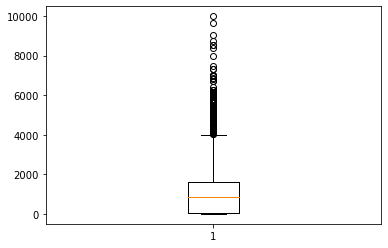

In [55]:
plt.boxplot(data_filtrées[data_filtrées["energy_100g"]<10000][["energy_100g"]])

On observe beaucoup d'outlier dans la feature energy avec des energy très nettement supérieur à 800.

In [41]:
data_filtrées["energy_100g"].value_counts()

0.100904       59652
0.000000        8873
2092.000000     5005
1674.000000     3801
1644.000000     3151
               ...  
135.500000         1
556.500000         1
0.600000           1
4431.000000        1
448.590000         1
Name: energy_100g, Length: 3863, dtype: int64

In [56]:
print("il y a ", len(data_filtrées[data_filtrées["energy_100g"] > 800]), "lignes d'ouliers")

il y a  143398 lignes d'ouliers


In [57]:
## Filtre les valeurs énergétique supérieur à 800.
## On considère qu'une valeur au dessu  de 800 est un outlier
##L'alimentt le plus calorique est de 859KCal/100G
data_filtrées = data_filtrées[data_filtrées["energy_100g"] < 800]

Il y beaucoup de lignes de valeurs abberantes. Il est préférable de les retirer car cela pourrait poser problèmes au dataset.

### Traitement des valeurs abberrantes dans les features 

On crée une list composée des features sans la feature energy. Cela a pour but de traiter les features différement de la feature energie.

In [61]:
##Colonnes sans energy_100G 


num_features_100_dropnrj = [
                             'proteins_100g',
                             'salt_100g',
                             'sodium_100g',
                             'ingredients_that_may_be_from_palm_oil_n',
                             'additives_n',
                             'sugars_100g',
                             'fat_100g',
                             'saturated-fat_100g',
                             'nutrition-score-fr_100g',
                             'nutrition-score-uk_100g',
                             'cholesterol_100g',
                             'trans-fat_100g',
                             'calcium_100g',
                             'vitamin-c_100g',
                             'carbohydrates_100g',
                             'fiber_100g',
                             'nutri grade number fr'
             ]

In [60]:
data_filtrées.describe()

,energy_100g,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,fiber_100g,nutri grade number fr
count,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000
mean,185.386102,2.040822,1.639101,0.672333,0.068367,1.141237,3.979961,1.509219,0.590304,1.862700,1.685637,0.078713,0.082309,0.092926,0.081821,6.037303,0.412041,1.168332
std,237.919864,4.843791,14.970912,5.891348,0.189223,1.965450,7.743736,3.941019,1.778266,3.611147,3.341811,0.042283,0.650801,0.915377,0.413383,13.174759,1.764671,1.389166
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100904
25%,0.100904,0.100904,0.100904,0.069000,0.000000,0.100904,0.100904,0.000000,0.100904,0.100904,0.100904,0.100904,0.000000,0.100904,0.032500,0.100904,0.100904,0.100904
50%,18.000000,0.100904,0.100904,0.100904,0.000000,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904,0.100904
75%,342.000000,1.400000,0.665480,0.262000,0.100904,2.000000,4.800000,0.500000,0.100904,2.000000,2.000000,0.100904,0.100904,0.100904,0.100904,9.380000,0.100904,2.000000
max,799.000000,100.000000,3048.000000,1200.000000,5.000000,26.000000,166.670000,100.000000,100.000000,30.000000,30.000000,0.996000,173.260000,285.714000,100.000000,2916.670000,250.000000,5.000000


On retire à présent, les valeurs supérieurs à 100 pour les features de 100G.

In [62]:
## Opération sur les colonnes
compteur_oulier_100G = 0
for col in num_features_100_dropnrj : 
    compteur_oulier_100G = compteur_oulier_100G + len(data_filtrées[col] > 100)
    data_filtrées = data_filtrées[data_filtrées[col] < 100]

In [51]:
print(f" il y a {compteur_oulier_100G}  d'ouliers avec des données abbérantes sur les quantités sur 100")

 il y a 2374987  d'ouliers avec des données abbérantes sur les quantités sur 100


On retire des valeurs abberantes car il est impossible d'avoir des valeurs de 100 G supérieurs à 100. Malgrès il y en ait un grand nombre nous sommes obligés d'enlever les valeurs abberrantes.

In [63]:
data_filtrées = data_filtrées.replace(fill_na,np.nan)

In [64]:
data_filtrées.head(4)

,product_name,countries_tags,brands,energy_100g,proteins_100g,pnns_groups_1,pnns_groups_2,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition_grade_fr,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,fiber_100g,nutri grade number fr
product_name + brands,,,,,,,,,,,,,,,,,,,,,,,,
Farine de blé noir Ferme t'y R'nao,Farine de blé noir,en:france,Ferme t'y R'nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Real Salt Granular Redmond,Real Salt Granular,en:united-states,Redmond,NaN,NaN,NaN,NaN,96.15678,37.857,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Filet de bœuf Sans marque,Filet de bœuf,en:france,Sans marque,NaN,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,en:france,Sans marque,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On compte les données avec des lignes avec beaucoup de données importantes manquantes. 

In [68]:
ouliters= data_filtrées [data_filtrées["energy_100g"].isna()
                            | data_filtrées["proteins_100g"].isna()
                            | data_filtrées["sugars_100g"].isna()
                            | data_filtrées["fat_100g"].isna()
                            | data_filtrées["saturated-fat_100g"].isna()
                            | data_filtrées["carbohydrates_100g"].isna()
                            | data_filtrées["sodium_100g"].isna() 
                            
                
                    ]

In [70]:
print(f" il y a {ouliters.shape[0]}  outliers de lignes avec beaucoup de données manquantes")

 il y a 87936  outliers de lignes avec beaucoup de données manquantes


In [71]:
data_filtrées.columns

Index(['product_name', 'countries_tags', 'brands', 'energy_100g',
       'proteins_100g', 'pnns_groups_1', 'pnns_groups_2', 'salt_100g',
       'sodium_100g', 'ingredients_that_may_be_from_palm_oil_n', 'additives_n',
       'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'nutrition_grade_fr',
       'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
       'cholesterol_100g', 'trans-fat_100g', 'calcium_100g', 'vitamin-c_100g',
       'carbohydrates_100g', 'fiber_100g', 'nutri grade number fr'],
      dtype='object')

In [72]:
data_filtrées = data_filtrées [data_filtrées["energy_100g"].notna()
                            | data_filtrées["proteins_100g"].notna()
                            | data_filtrées["sugars_100g"].notna()
                            | data_filtrées["fat_100g"].notna()
                            | data_filtrées["saturated-fat_100g"].notna()
                            | data_filtrées["carbohydrates_100g"].notna()
                            | data_filtrées["sodium_100g"].notna() 
                    ]

On décide de les supprimer car ces données vont influencer notre imputation de données en la rendant plus compliquées. Effectivement s'il y a beaucoup de feature clées manquantes, ces données vont être remplacé par des valeurs. Mais cela va grandement influencer la ligne.

In [75]:
print(f" il y a {data_filtrées.shape[0]} lignes dans le dataset")

 il y a 81278 lignes dans le dataset


## Les nutricores non existants

On compte et enlève les lignes avec un nutriscore manquant. 

In [76]:
outliers_nutriscore= data_filtrées [
                            data_filtrées["nutrition-score-fr_100g"].isna()
                            | data_filtrées['nutri grade number fr'].isna()
                
                    ]

In [77]:
print(f" il y a {outliers_nutriscore.shape[0]} lignes d'outliers avec des nutriscores manquants")

 il y a 24646 lignes d'outliers avec des nutriscores manquants


In [78]:
data_filtrées = data_filtrées [
                                data_filtrées["nutrition-score-fr_100g"].notna()
                            | data_filtrées['nutri grade number fr'].notna()
]

In [79]:
print(f" il y a {data_filtrées.shape[0]} lignes dans le dataset finale")

 il y a 56632 lignes dans le dataset finale


In [80]:
dic= {}

for col in data_filtrées.columns :
    dic[col] = data_filtrées[col].isna().sum()
    
## Transformation du dictionnaire en Dataframe    
var_dic = pd.DataFrame([dic],columns=dic.keys())

In [82]:
data_filtrées.isna().sum()

product_name                                 763
countries_tags                                15
brands                                         0
energy_100g                                    0
proteins_100g                                  0
pnns_groups_1                              39268
pnns_groups_2                              39192
salt_100g                                      0
sodium_100g                                    0
ingredients_that_may_be_from_palm_oil_n     7429
additives_n                                 7429
sugars_100g                                    0
fat_100g                                    5210
saturated-fat_100g                             0
nutrition_grade_fr                             0
nutrition-score-fr_100g                        0
nutrition-score-uk_100g                        0
cholesterol_100g                           24171
trans-fat_100g                             24655
calcium_100g                               24411
vitamin-c_100g      

On tracé un graphique des données pour voir leurs homogénéités 

In [83]:
plot_1 = [ 'proteins_100g','ingredients_that_may_be_from_palm_oil_n', 'additives_n',
       'sugars_100g', 'fat_100g',"carbohydrates_100g" ]

plot_2 = ['saturated-fat_100g',
       'cholesterol_100g', 'trans-fat_100g', 'calcium_100g', 'vitamin-c_100g',"fiber_100g"]

Text(0.5, 1.0, 'Valeur Différentes de NAN')

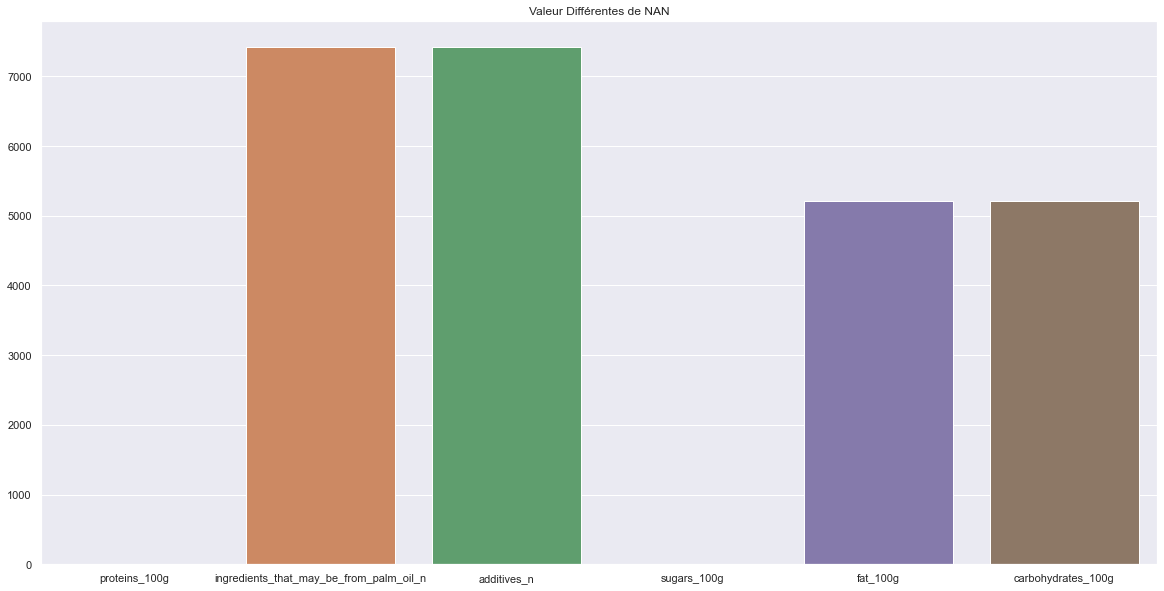

In [84]:
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(data = var_dic[plot_1])
plt.title('Valeur Différentes de NAN')

Text(0.5, 1.0, 'Valeur Différentes de NAN')

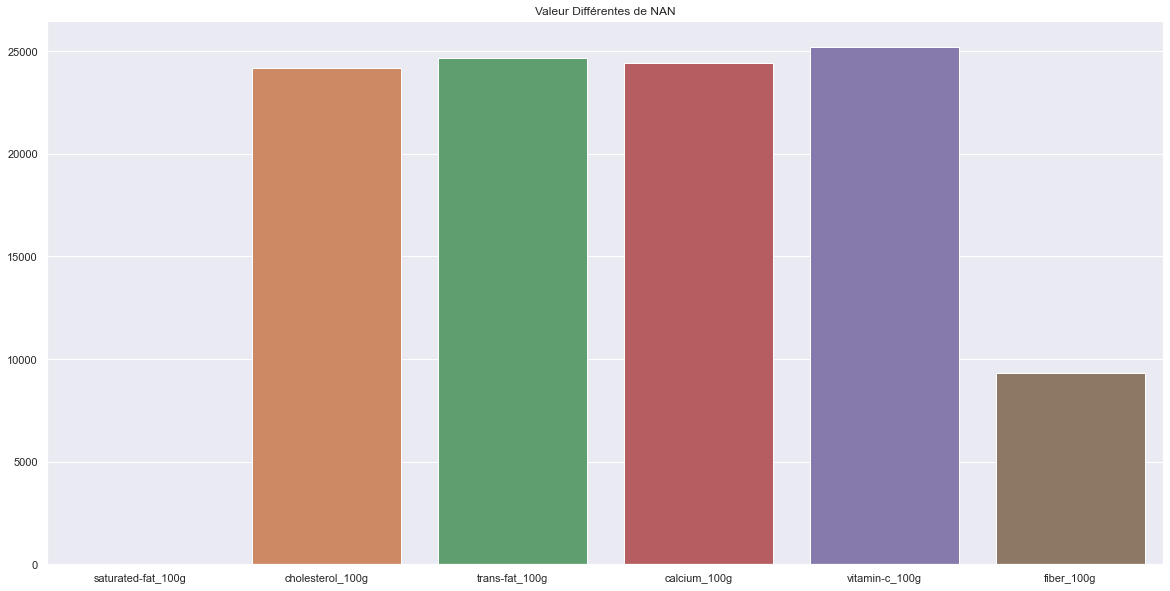

In [85]:
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(data = var_dic[plot_2])
plt.title('Valeur Différentes de NAN')

On remarque que les features ont un nombre très hétérogènes de features. Cela veut dire que certaines features seront très impactés par le traitement de valeurs manquantes. Par exemple la feature chlesterol et la feature calcium auront la moitié leurs valeurs remplacé par le traitement des valeurs manquantes.

# Milestone 3 : Nettoyage – valeurs manquantes

Dans cette milestone 3, une fois avoir traiter les valeurs abberantes, on va chercher à remplacer les valeurs manquantes. Pour cela on va remplacer les valeurs manquantes en utilisant 3 méthodes :
- Remplacement par la mediane par catégorie
- Remplacement par les K plus proches voisins
- Remplacement par régression.

## Variables catégorielles

In [86]:
data_filtrées[num_features].describe()

,energy_100g,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,fiber_100g,nutri grade number fr
count,56632.000000,56632.000000,56632.000000,56632.000000,49203.000000,49203.000000,56632.000000,51422.000000,56632.000000,56632.000000,56632.000000,32461.000000,31977.000000,32221.000000,31407.000000,51421.000000,47295.000000,56632.000000
mean,372.486162,4.281038,1.562554,0.615178,0.047131,1.918542,7.116608,3.099946,1.214938,4.432953,3.995444,0.011624,0.016551,0.049737,0.009515,11.372408,0.832320,2.725155
std,221.438163,6.278358,6.341373,2.496595,0.229510,2.294926,8.355219,4.201500,2.394057,4.568181,4.286735,0.027611,0.445972,0.426162,0.092105,10.429130,1.889936,0.814559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,192.000000,0.158000,0.086360,0.034000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.200000,0.000000,2.000000
50%,363.000000,1.670000,0.627380,0.247000,0.000000,1.000000,4.000000,1.500000,0.300000,3.000000,2.000000,0.000000,0.000000,0.016000,0.001100,9.090000,0.300000,3.000000
75%,550.000000,4.760000,1.300000,0.511811,0.000000,3.000000,11.000000,4.710000,1.760000,6.000000,5.000000,0.012000,0.000000,0.067000,0.008000,15.570000,1.300000,3.000000
max,799.000000,93.330000,99.930000,39.342520,3.000000,24.000000,99.000000,92.000000,99.000000,30.000000,30.000000,0.996000,30.000000,69.500000,12.000000,99.300000,99.000000,5.000000


In [87]:
data_filtrées.head()

,product_name,countries_tags,brands,energy_100g,proteins_100g,pnns_groups_1,pnns_groups_2,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition_grade_fr,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,fiber_100g,nutri grade number fr
product_name + brands,,,,,,,,,,,,,,,,,,,,,,,,
Quiche Lorraine Kirkland Signature,Quiche Lorraine,en:canada,Kirkland Signature,478.0,5.36,Composite foods,Pizza pies and quiche,0.49900,0.19600,0.0,3.0,0.714,6.79,2.86,b,2.0,2.0,0.0107,0.0,0.0286,0.000429,7.86,0.357,2.0
"Pepsi, Nouveau goût ! Pepsi","Pepsi, Nouveau goût !",en:france,Pepsi,177.0,0.00,Beverages,Sweetened beverages,0.02540,0.01000,0.0,2.0,10.400,0.00,0.00,e,13.0,2.0,NaN,NaN,NaN,NaN,10.40,0.000,5.0
"7Up 7Up,Pepsico",7Up,en:france,"7Up,Pepsico",177.0,0.00,Beverages,Sweetened beverages,0.10000,0.03937,0.0,3.0,10.400,0.00,0.00,e,13.0,2.0,NaN,NaN,NaN,NaN,10.40,NaN,5.0
"Ryan's, Juice Melange, Fuji Pom Blend Ryan Orchards","Ryan's, Juice Melange, Fuji Pom Blend",en:united-states,Ryan Orchards,192.0,0.00,NaN,NaN,0.03810,0.01500,0.0,0.0,10.420,0.00,0.00,b,2.0,2.0,0.0000,0.0,0.0000,0.000000,11.67,0.000,2.0
"Ryan's, Lemonade Ryan Orchards","Ryan's, Lemonade",en:united-states,Ryan Orchards,226.0,0.00,NaN,NaN,0.01016,0.00400,0.0,0.0,13.330,0.00,0.00,b,2.0,2.0,0.0000,0.0,0.0000,0.000500,13.33,0.000,2.0


## On remplace les valeurs des features catégorielles inconnues  

In [88]:
data_filtrées[["pnns_groups_1"]] = data_filtrées[["pnns_groups_1"]].fillna("unknown")
data_filtrées[["pnns_groups_2"]] = data_filtrées[["pnns_groups_2"]].fillna("unknown")
data_filtrées[["product_name"]] = data_filtrées[["product_name"]].fillna("Unknown Product")
data_filtrées[["product_name"]] = data_filtrées[["product_name"]].fillna("Unknown Countries")

In [89]:
data_missing_treated = data_filtrées.copy()
data_MEDIANE = data_missing_treated.copy()
data_KNNI = data_missing_treated.copy()
data_ITERATIVE = data_missing_treated.copy()

Création d'une liste des variables qu'on va traiter

In [90]:
features = ['proteins_100g', 'salt_100g', 'sodium_100g',
       'ingredients_that_may_be_from_palm_oil_n', 'additives_n', 'sugars_100g',
       'fat_100g', 'saturated-fat_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'cholesterol_100g', 'trans-fat_100g',
       'calcium_100g', 'vitamin-c_100g', 'carbohydrates_100g', 'energy_100g','fiber_100g', 'nutri grade number fr']

### Mediane 

Par catégorie

array([[<AxesSubplot:title={'center':'proteins_100g'}>,
        <AxesSubplot:title={'center':'salt_100g'}>,
        <AxesSubplot:title={'center':'sodium_100g'}>,
        <AxesSubplot:title={'center':'ingredients_that_may_be_from_palm_oil_n'}>],
       [<AxesSubplot:title={'center':'additives_n'}>,
        <AxesSubplot:title={'center':'sugars_100g'}>,
        <AxesSubplot:title={'center':'fat_100g'}>,
        <AxesSubplot:title={'center':'saturated-fat_100g'}>],
       [<AxesSubplot:title={'center':'nutrition-score-fr_100g'}>,
        <AxesSubplot:title={'center':'nutrition-score-uk_100g'}>,
        <AxesSubplot:title={'center':'cholesterol_100g'}>,
        <AxesSubplot:title={'center':'trans-fat_100g'}>],
       [<AxesSubplot:title={'center':'calcium_100g'}>,
        <AxesSubplot:title={'center':'vitamin-c_100g'}>,
        <AxesSubplot:title={'center':'carbohydrates_100g'}>,
        <AxesSubplot:title={'center':'energy_100g'}>],
       [<AxesSubplot:title={'center':'fiber_100g'}>,
    

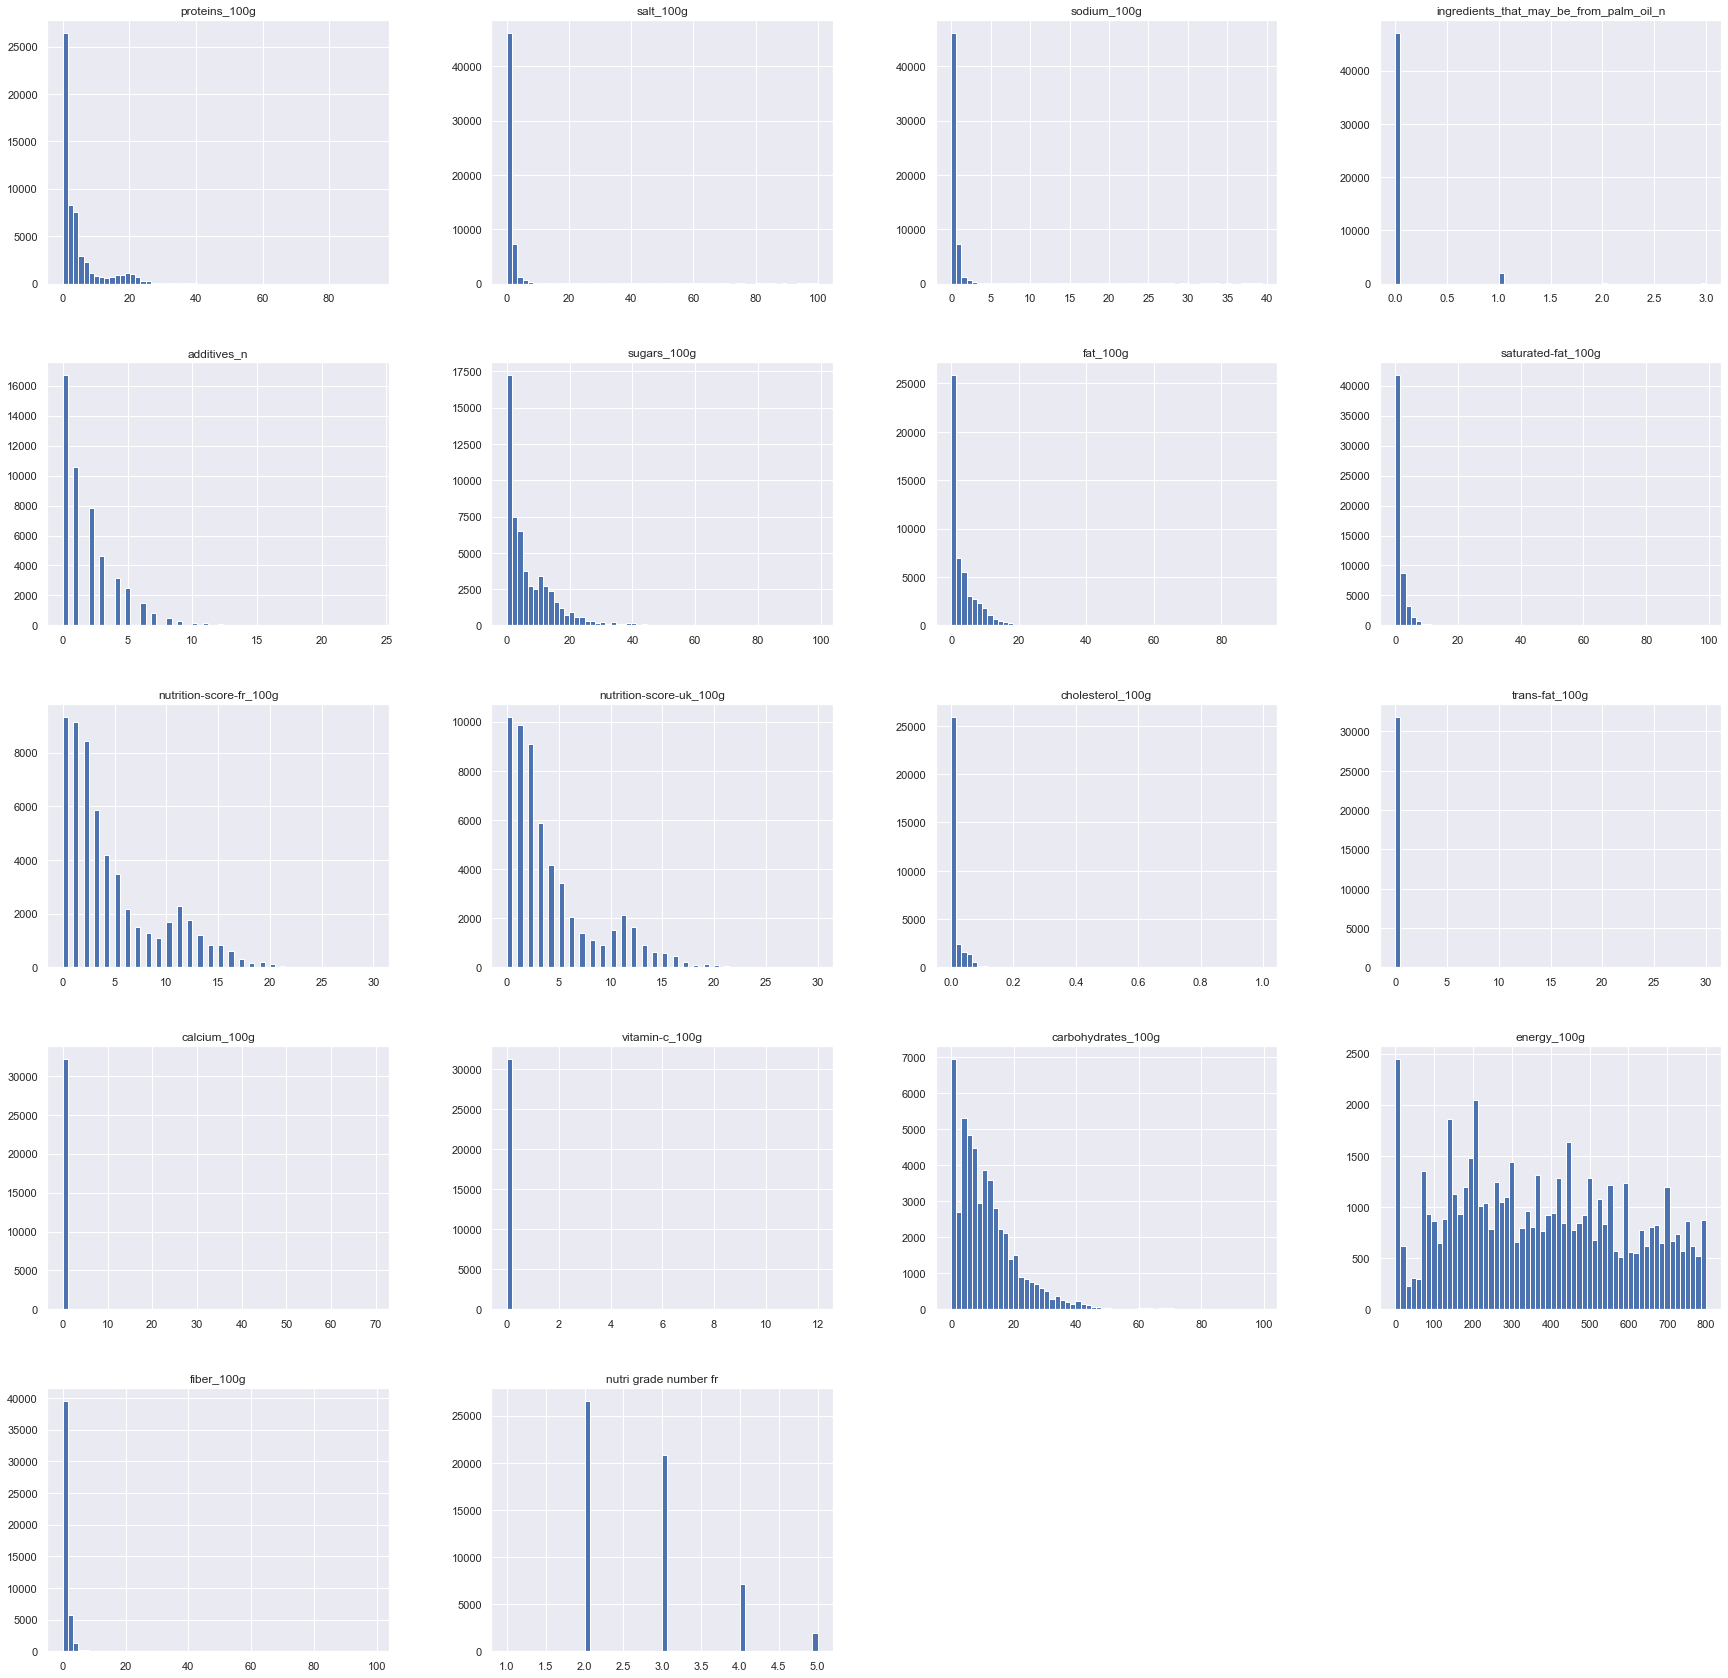

In [91]:
data_MEDIANE[features ].hist(bins=60, figsize=(30, 30), color = "r")

On remplace par la mediane les valeurs manquantes par catégories.

In [92]:
for i in data_MEDIANE["pnns_groups_1"].unique():
    data_MEDIANE.loc[data_MEDIANE["pnns_groups_1"]== i]
    
    for col in features :
        data_MEDIANE.loc[data_MEDIANE["pnns_groups_1"]== i, col] = data_MEDIANE.loc[data_MEDIANE["pnns_groups_1"]== i, col].fillna(value =data_MEDIANE.loc[data_MEDIANE["pnns_groups_1"]== i, col].median()) 


In [93]:
data_MEDIANE.describe()

,energy_100g,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,fiber_100g,nutri grade number fr
count,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56512.000000,56630.000000,56630.000000,56512.000000,56632.000000,56632.000000,56632.000000
mean,372.486162,4.281038,1.562554,0.615178,0.040949,1.816305,7.116608,2.916773,1.214938,4.432953,3.995444,0.009093,0.009551,0.045494,0.006489,11.200646,0.760776,2.725155
std,221.438163,6.278358,6.341373,2.496595,0.214518,2.159871,8.355219,4.052174,2.394057,4.568181,4.286735,0.022720,0.335245,0.322930,0.068820,9.979331,1.746812,0.814559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,192.000000,0.158000,0.086360,0.034000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.700000,0.000000,2.000000
50%,363.000000,1.670000,0.627380,0.247000,0.000000,1.000000,4.000000,1.000000,0.300000,3.000000,2.000000,0.000000,0.000000,0.015000,0.001000,9.580000,0.100000,3.000000
75%,550.000000,4.760000,1.300000,0.511811,0.000000,2.000000,11.000000,4.230000,1.760000,6.000000,5.000000,0.007780,0.000000,0.068000,0.006000,14.620000,1.200000,3.000000
max,799.000000,93.330000,99.930000,39.342520,3.000000,24.000000,99.000000,92.000000,99.000000,30.000000,30.000000,0.996000,30.000000,69.500000,12.000000,99.300000,99.000000,5.000000


In [94]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
data_MEDIANE[features ]= imp_median.fit_transform(data_MEDIANE[features ])
data_MEDIANE[features ].head(5)

,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,energy_100g,fiber_100g,nutri grade number fr
product_name + brands,,,,,,,,,,,,,,,,,,
Quiche Lorraine Kirkland Signature,5.36,0.49900,0.19600,0.0,3.0,0.714,6.79,2.86,2.0,2.0,0.0107,0.0,0.0286,0.000429,7.86,478.0,0.357,2.0
"Pepsi, Nouveau goût ! Pepsi",0.00,0.02540,0.01000,0.0,2.0,10.400,0.00,0.00,13.0,2.0,0.0000,0.0,0.1200,0.012000,10.40,177.0,0.000,5.0
"7Up 7Up,Pepsico",0.00,0.10000,0.03937,0.0,3.0,10.400,0.00,0.00,13.0,2.0,0.0000,0.0,0.1200,0.012000,10.40,177.0,0.000,5.0
"Ryan's, Juice Melange, Fuji Pom Blend Ryan Orchards",0.00,0.03810,0.01500,0.0,0.0,10.420,0.00,0.00,2.0,2.0,0.0000,0.0,0.0000,0.000000,11.67,192.0,0.000,2.0
"Ryan's, Lemonade Ryan Orchards",0.00,0.01016,0.00400,0.0,0.0,13.330,0.00,0.00,2.0,2.0,0.0000,0.0,0.0000,0.000500,13.33,226.0,0.000,2.0


array([[<AxesSubplot:title={'center':'proteins_100g'}>,
        <AxesSubplot:title={'center':'salt_100g'}>,
        <AxesSubplot:title={'center':'sodium_100g'}>,
        <AxesSubplot:title={'center':'ingredients_that_may_be_from_palm_oil_n'}>],
       [<AxesSubplot:title={'center':'additives_n'}>,
        <AxesSubplot:title={'center':'sugars_100g'}>,
        <AxesSubplot:title={'center':'fat_100g'}>,
        <AxesSubplot:title={'center':'saturated-fat_100g'}>],
       [<AxesSubplot:title={'center':'nutrition-score-fr_100g'}>,
        <AxesSubplot:title={'center':'nutrition-score-uk_100g'}>,
        <AxesSubplot:title={'center':'cholesterol_100g'}>,
        <AxesSubplot:title={'center':'trans-fat_100g'}>],
       [<AxesSubplot:title={'center':'calcium_100g'}>,
        <AxesSubplot:title={'center':'vitamin-c_100g'}>,
        <AxesSubplot:title={'center':'carbohydrates_100g'}>,
        <AxesSubplot:title={'center':'energy_100g'}>],
       [<AxesSubplot:title={'center':'fiber_100g'}>,
    

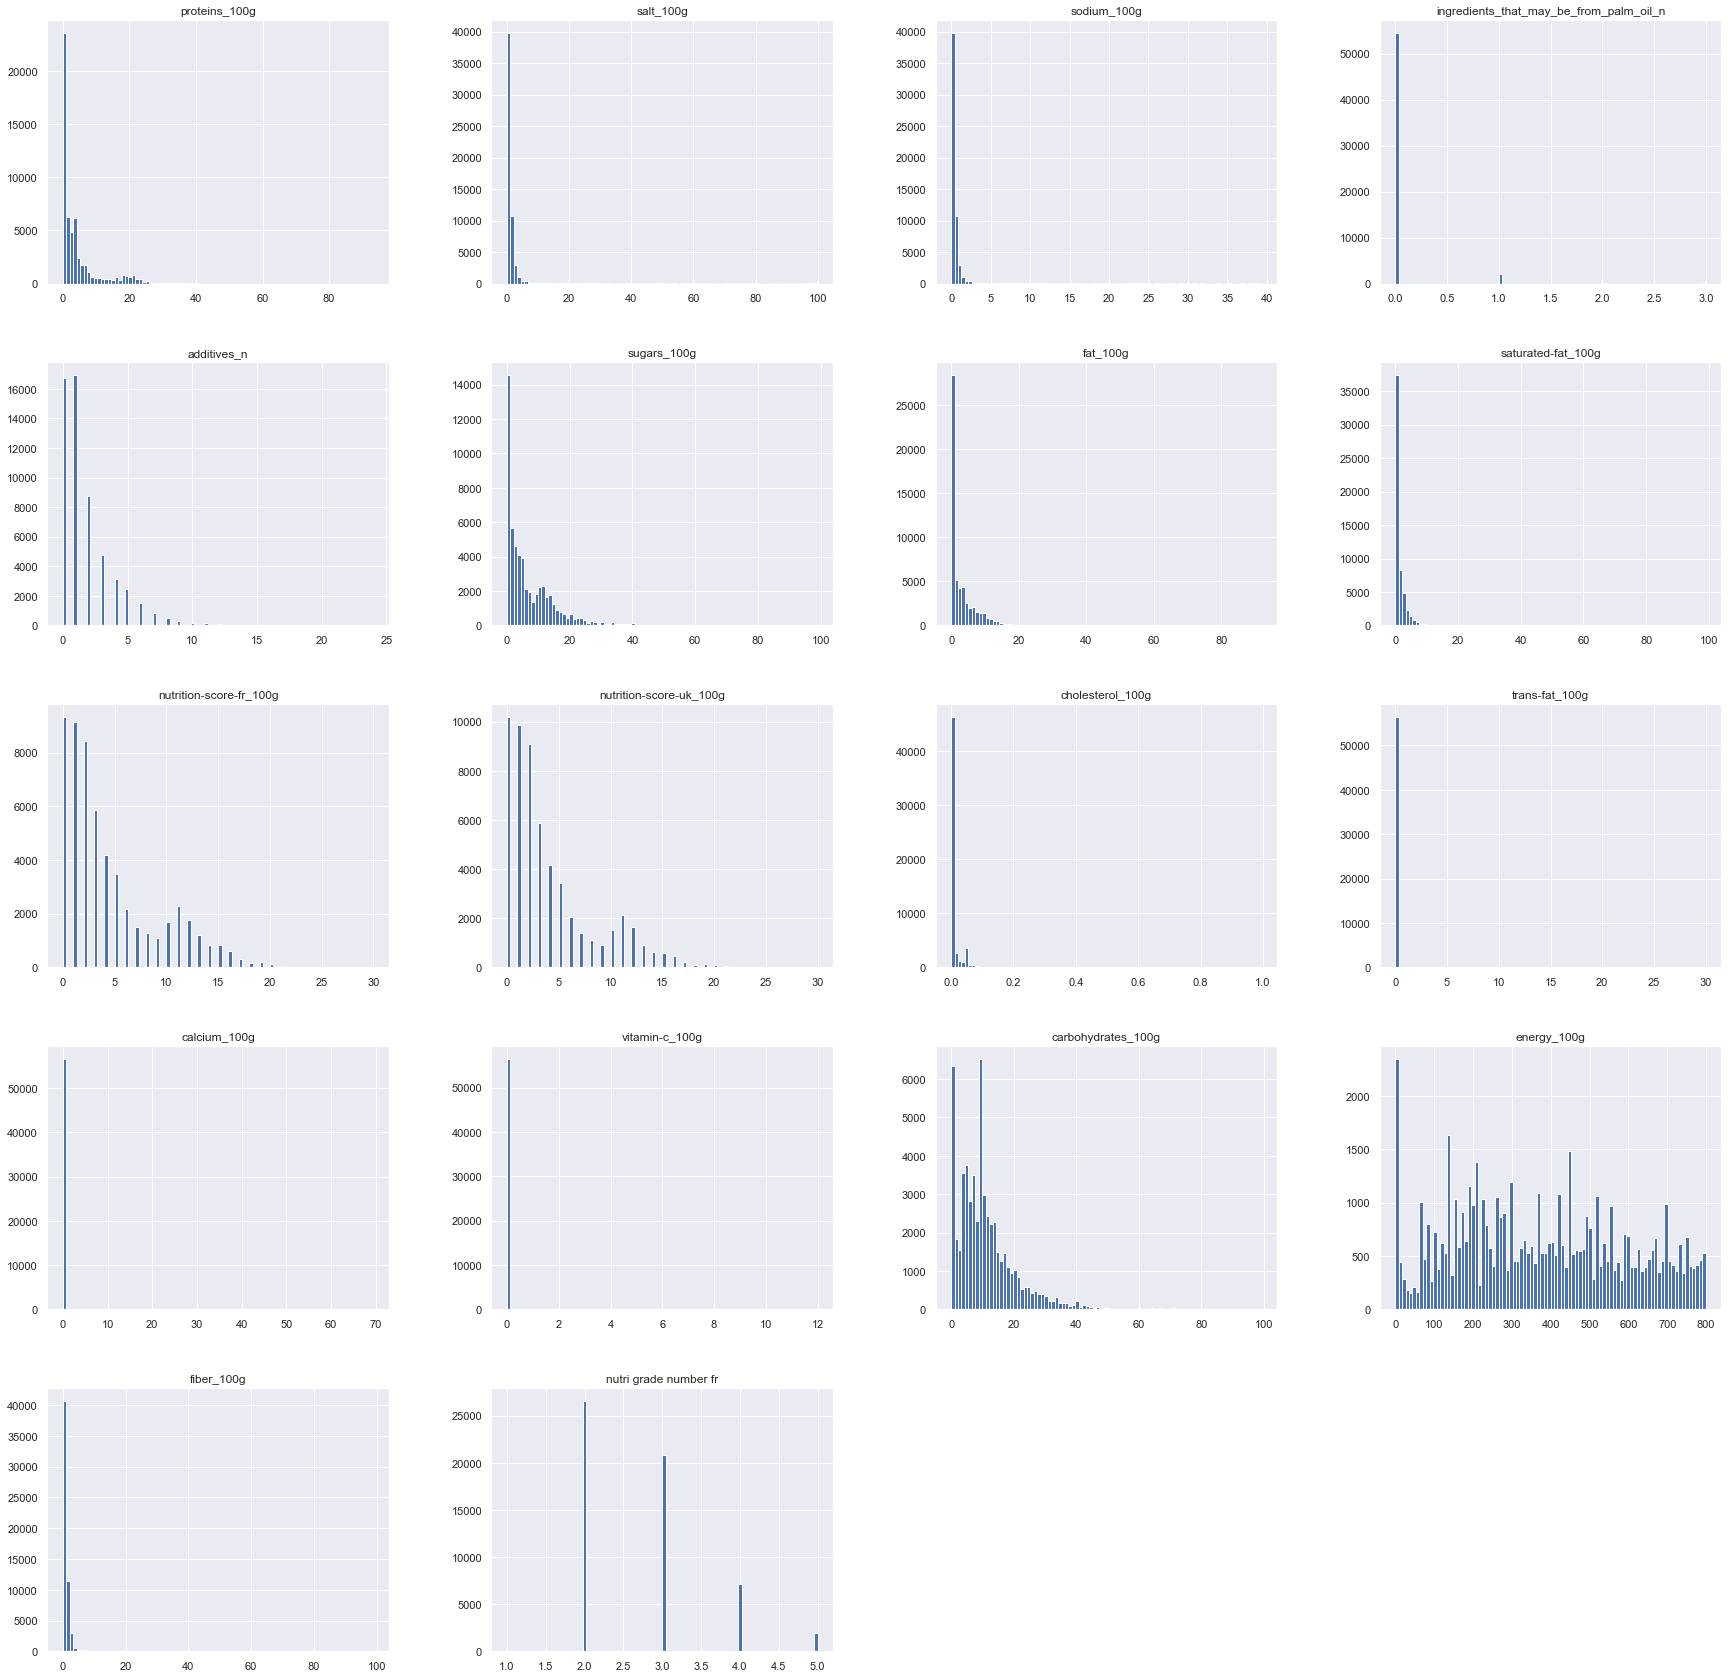

In [95]:
data_MEDIANE[features ].hist(bins=90, figsize=(30, 30))

In [96]:
 data_MEDIANE.describe()

,energy_100g,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,fiber_100g,nutri grade number fr
count,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000
mean,372.486162,4.281038,1.562554,0.615178,0.040949,1.816305,7.116608,2.916773,1.214938,4.432953,3.995444,0.009073,0.009550,0.045492,0.006477,11.200646,0.760776,2.725155
std,221.438163,6.278358,6.341373,2.496595,0.214518,2.159871,8.355219,4.052174,2.394057,4.568181,4.286735,0.022700,0.335239,0.322924,0.068748,9.979331,1.746812,0.814559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,192.000000,0.158000,0.086360,0.034000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.700000,0.000000,2.000000
50%,363.000000,1.670000,0.627380,0.247000,0.000000,1.000000,4.000000,1.000000,0.300000,3.000000,2.000000,0.000000,0.000000,0.015000,0.001000,9.580000,0.100000,3.000000
75%,550.000000,4.760000,1.300000,0.511811,0.000000,2.000000,11.000000,4.230000,1.760000,6.000000,5.000000,0.007780,0.000000,0.068000,0.005900,14.620000,1.200000,3.000000
max,799.000000,93.330000,99.930000,39.342520,3.000000,24.000000,99.000000,92.000000,99.000000,30.000000,30.000000,0.996000,30.000000,69.500000,12.000000,99.300000,99.000000,5.000000


Des données très intéressantes. Malheuresmeent on a 70% de la données des catégories PNN 1 qui a été utilisé pour l'imputation par la mediane. Seulement 30% de la données est cohérente et le reste et de la données par défaut. Le remplissage par la mediane a donc des limites, beaucoup de données comblé par la moyen qui a des limites, on ne poursuivra pas avec cette données.

### Iterative imputer

In [97]:
from sklearn.impute import IterativeImputer

Remplissage par la médiane, à condition de le faire sur des produits homogènes, donc par catégorie de produit (pnns_group_1 par exemple)
Remplissage par un IterativeImputer sur les features corrélées entre elles (analyse via heatmap de corrélation), car la base de ce traitement est par défaut une régression linéaire. Par exemple la feature « salt » n’est corrélée à aucune autre feature, donc il n’est pas pertinent de le faire dans ce cas. Par contre les features « energy », « fat », « satured_fat », « sugar », « carbohydrates » ont des corrélations avec certaines des autres features citées, donc sont éligibles à ce traitement
Avantage : cette approche est très rapide à mettre en œuvre
Inconvénient : c’est une boîte noire, il n’y a pas de mesure de la pertinence de ce traitement (pas de scoring)

In [98]:
I_imp = IterativeImputer(missing_values=np.nan, random_state= 1,max_iter = 15,n_nearest_features = 7, initial_strategy = "median", imputation_order = "ascending", min_value = 0.01, max_value = 100)

In [99]:
data_ITERATIVE[features] =I_imp.fit_transform(data_ITERATIVE[features])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [100]:
data_ITERATIVE[features].head(5)

,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,energy_100g,fiber_100g,nutri grade number fr
product_name + brands,,,,,,,,,,,,,,,,,,
Quiche Lorraine Kirkland Signature,5.36,0.49900,0.19600,0.0,3.0,0.714,6.79,2.86,2.0,2.0,0.0107,0.00,0.028600,0.000429,7.86,478.0,0.357,2.0
"Pepsi, Nouveau goût ! Pepsi",0.00,0.02540,0.01000,0.0,2.0,10.400,0.00,0.00,13.0,2.0,0.0100,0.01,0.035289,0.013966,10.40,177.0,0.000,5.0
"7Up 7Up,Pepsico",0.00,0.10000,0.03937,0.0,3.0,10.400,0.00,0.00,13.0,2.0,0.0100,0.01,0.039255,0.013966,10.40,177.0,0.010,5.0
"Ryan's, Juice Melange, Fuji Pom Blend Ryan Orchards",0.00,0.03810,0.01500,0.0,0.0,10.420,0.00,0.00,2.0,2.0,0.0000,0.00,0.000000,0.000000,11.67,192.0,0.000,2.0
"Ryan's, Lemonade Ryan Orchards",0.00,0.01016,0.00400,0.0,0.0,13.330,0.00,0.00,2.0,2.0,0.0000,0.00,0.000000,0.000500,13.33,226.0,0.000,2.0


array([[<AxesSubplot:title={'center':'proteins_100g'}>,
        <AxesSubplot:title={'center':'salt_100g'}>,
        <AxesSubplot:title={'center':'sodium_100g'}>,
        <AxesSubplot:title={'center':'ingredients_that_may_be_from_palm_oil_n'}>],
       [<AxesSubplot:title={'center':'additives_n'}>,
        <AxesSubplot:title={'center':'sugars_100g'}>,
        <AxesSubplot:title={'center':'fat_100g'}>,
        <AxesSubplot:title={'center':'saturated-fat_100g'}>],
       [<AxesSubplot:title={'center':'nutrition-score-fr_100g'}>,
        <AxesSubplot:title={'center':'nutrition-score-uk_100g'}>,
        <AxesSubplot:title={'center':'cholesterol_100g'}>,
        <AxesSubplot:title={'center':'trans-fat_100g'}>],
       [<AxesSubplot:title={'center':'calcium_100g'}>,
        <AxesSubplot:title={'center':'vitamin-c_100g'}>,
        <AxesSubplot:title={'center':'carbohydrates_100g'}>,
        <AxesSubplot:title={'center':'energy_100g'}>],
       [<AxesSubplot:title={'center':'fiber_100g'}>,
    

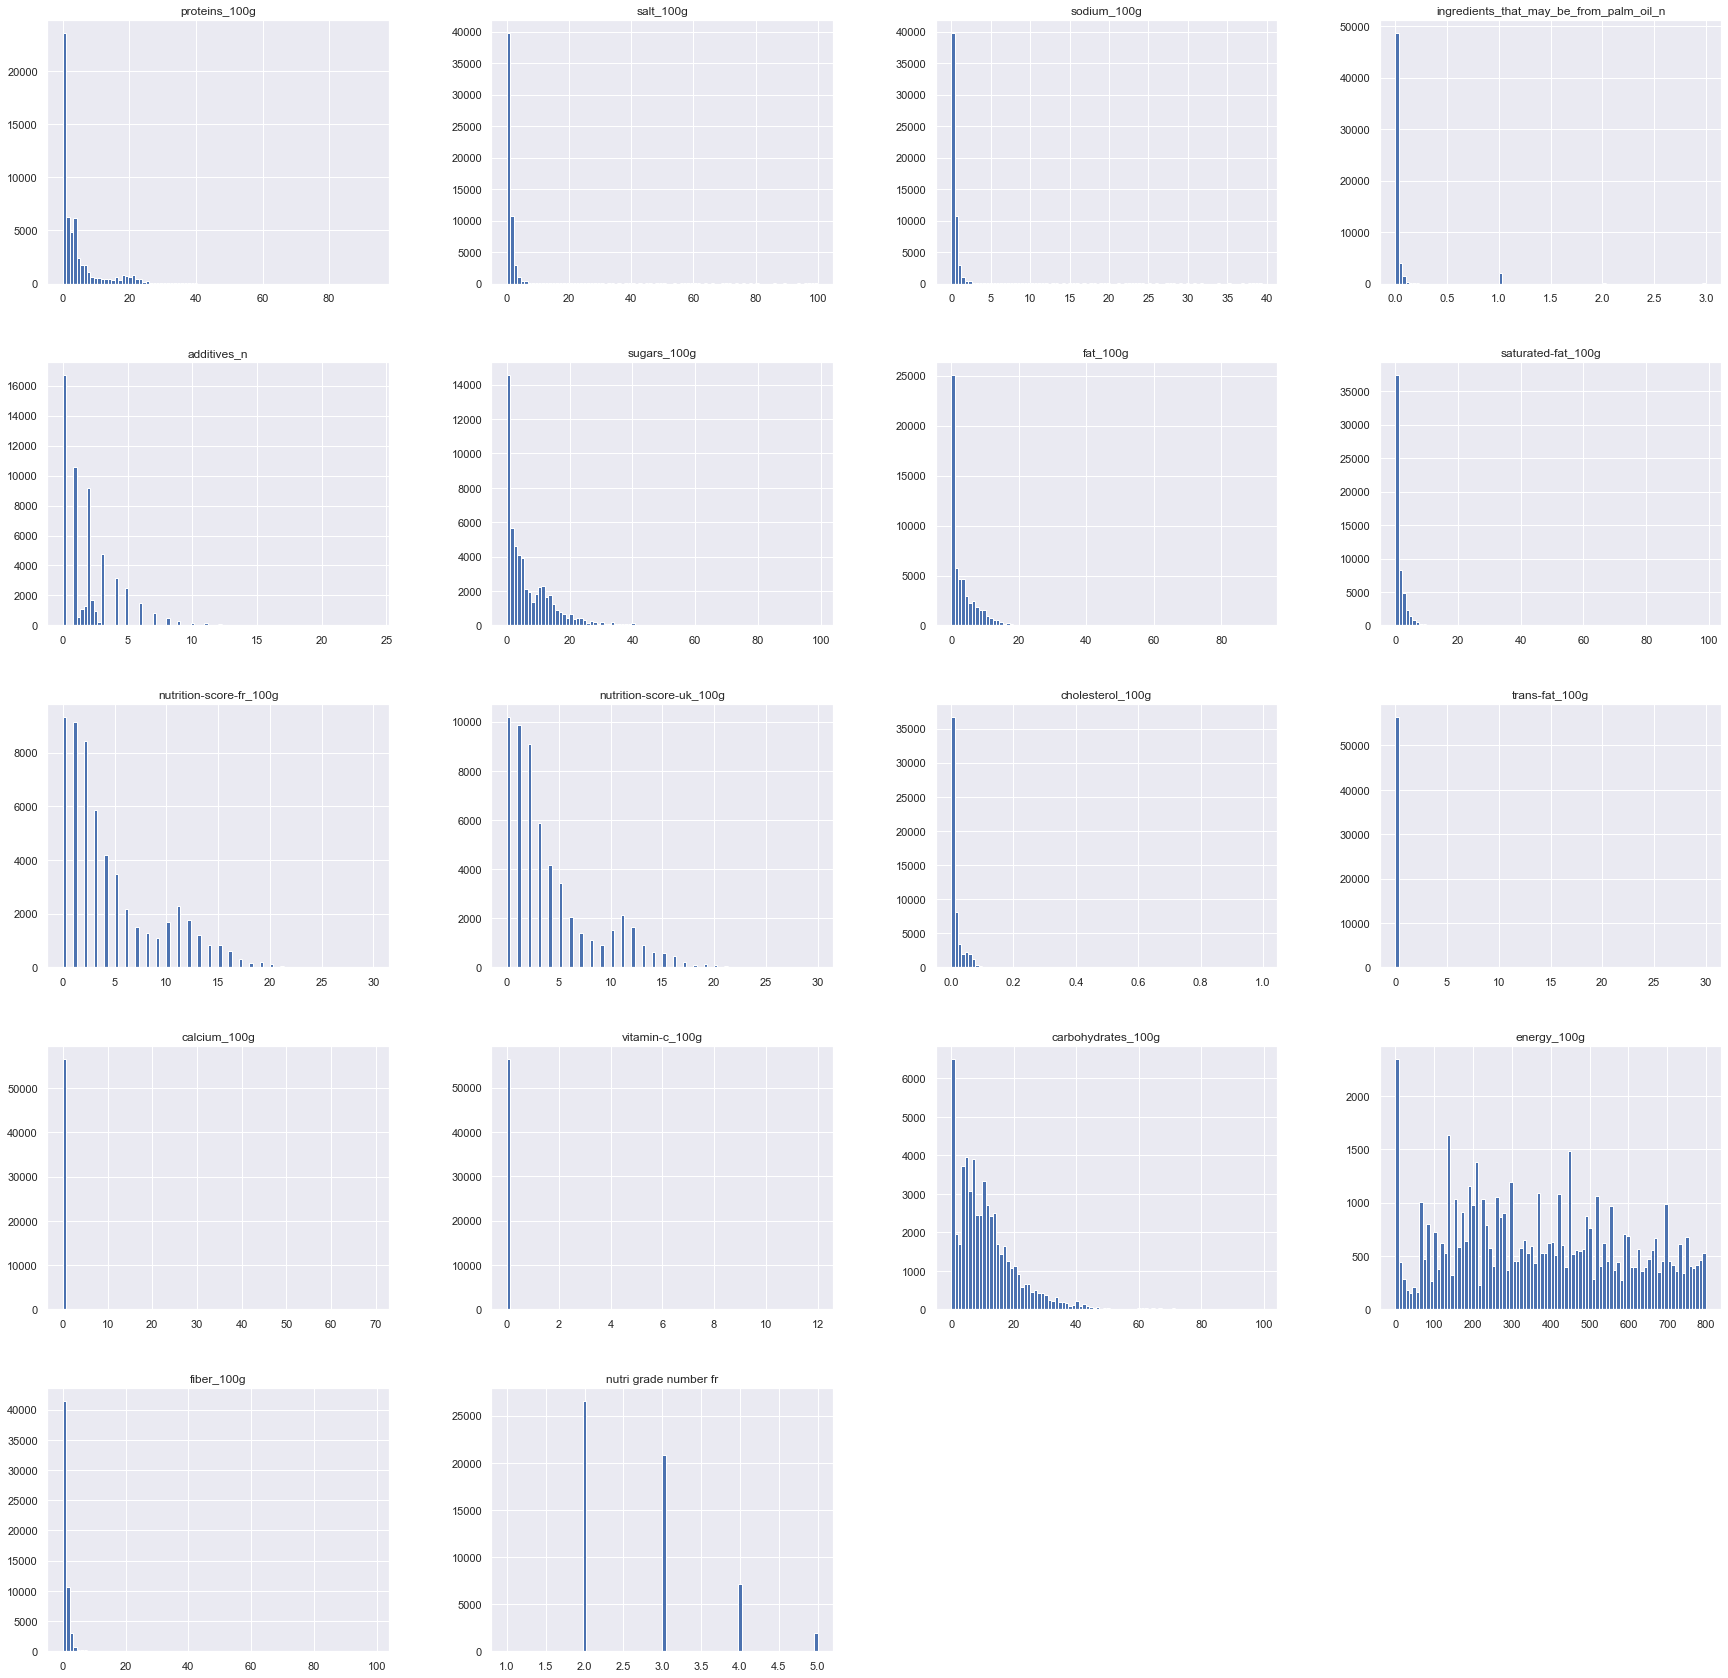

In [101]:
data_ITERATIVE[features ].hist(bins=90, figsize=(30, 30), color = "v")

In [102]:
data_ITERATIVE.describe()

,energy_100g,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,fiber_100g,nutri grade number fr
count,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000
mean,372.486162,4.281038,1.562554,0.615178,0.047969,1.929007,7.116608,3.178592,1.214938,4.432953,3.995444,0.015714,0.019514,0.053700,0.010243,11.431061,0.812028,2.725155
std,221.438163,6.278358,6.341373,2.496595,0.214190,2.146158,8.355219,4.273118,2.394057,4.568181,4.286735,0.024857,0.335372,0.322653,0.068606,10.295882,1.744002,0.814559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,192.000000,0.158000,0.086360,0.034000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.008000,0.000500,4.500000,0.000000,2.000000
50%,363.000000,1.670000,0.627380,0.247000,0.000000,1.470985,4.000000,1.600000,0.300000,3.000000,2.000000,0.010000,0.000000,0.036000,0.010000,9.300000,0.445182,3.000000
75%,550.000000,4.760000,1.300000,0.511811,0.000000,3.000000,11.000000,4.900000,1.760000,6.000000,5.000000,0.018000,0.012131,0.071769,0.011422,15.500000,1.165975,3.000000
max,799.000000,93.330000,99.930000,39.342520,3.000000,24.000000,99.000000,92.000000,99.000000,30.000000,30.000000,0.996000,30.000000,69.500000,12.000000,99.300000,99.000000,5.000000


Cette méthode fonctionne grâce à une regression linéaire. ça reste une boite noire et on a pas les informations sur les metrics de la regression. Donc on ne connait pas la précision des valeurs obtenues. 

### KNN 

In [103]:
imputeur = KNNImputer(missing_values= np.nan, n_neighbors  = 3, weights = "distance")

In [104]:
imputeur.fit(data_KNNI[features ])

KNNImputer(n_neighbors=3, weights='distance')

In [105]:
data_KNNI[features ] = imputeur.transform(data_KNNI[features ])

In [107]:
data_KNNI[features ].head(5) 

,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,energy_100g,fiber_100g,nutri grade number fr
product_name + brands,,,,,,,,,,,,,,,,,,
Quiche Lorraine Kirkland Signature,5.36,0.49900,0.19600,0.0,3.0,0.714,6.79,2.86,2.0,2.0,0.010700,0.000000,0.028600,0.000429,7.86,478.0,0.357,2.0
"Pepsi, Nouveau goût ! Pepsi",0.00,0.02540,0.01000,0.0,2.0,10.400,0.00,0.00,13.0,2.0,0.000619,0.015453,0.029142,0.013778,10.40,177.0,0.000,5.0
"7Up 7Up,Pepsico",0.00,0.10000,0.03937,0.0,3.0,10.400,0.00,0.00,13.0,2.0,0.000645,0.016099,0.028878,0.014188,10.40,177.0,0.000,5.0
"Ryan's, Juice Melange, Fuji Pom Blend Ryan Orchards",0.00,0.03810,0.01500,0.0,0.0,10.420,0.00,0.00,2.0,2.0,0.000000,0.000000,0.000000,0.000000,11.67,192.0,0.000,2.0
"Ryan's, Lemonade Ryan Orchards",0.00,0.01016,0.00400,0.0,0.0,13.330,0.00,0.00,2.0,2.0,0.000000,0.000000,0.000000,0.000500,13.33,226.0,0.000,2.0


In [108]:
data_KNNI[features ] .describe()

,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,energy_100g,fiber_100g,nutri grade number fr
count,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000
mean,4.281038,1.562554,0.615178,0.048094,1.934083,7.116608,3.146441,1.214938,4.432953,3.995444,0.013879,0.016552,0.056275,0.008578,11.397308,372.486162,0.761140,2.725155
std,6.278358,6.341373,2.496595,0.222585,2.256452,8.355219,4.224474,2.394057,4.568181,4.286735,0.027947,0.354702,0.504931,0.075342,10.501408,221.438163,1.754817,0.814559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.158000,0.086360,0.034000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.230000,192.000000,0.000000,2.000000
50%,1.670000,0.627380,0.247000,0.000000,1.000000,4.000000,1.560000,0.300000,3.000000,2.000000,0.000000,0.000000,0.019640,0.001837,9.170000,363.000000,0.200000,3.000000
75%,4.760000,1.300000,0.511811,0.000000,3.000000,11.000000,4.800000,1.760000,6.000000,5.000000,0.015331,0.000000,0.071000,0.008000,15.570000,550.000000,1.100000,3.000000
max,93.330000,99.930000,39.342520,3.000000,24.000000,99.000000,92.000000,99.000000,30.000000,30.000000,0.996000,30.000000,69.500000,12.000000,99.300000,799.000000,99.000000,5.000000


array([[<AxesSubplot:title={'center':'proteins_100g'}>,
        <AxesSubplot:title={'center':'salt_100g'}>,
        <AxesSubplot:title={'center':'sodium_100g'}>,
        <AxesSubplot:title={'center':'ingredients_that_may_be_from_palm_oil_n'}>],
       [<AxesSubplot:title={'center':'additives_n'}>,
        <AxesSubplot:title={'center':'sugars_100g'}>,
        <AxesSubplot:title={'center':'fat_100g'}>,
        <AxesSubplot:title={'center':'saturated-fat_100g'}>],
       [<AxesSubplot:title={'center':'nutrition-score-fr_100g'}>,
        <AxesSubplot:title={'center':'nutrition-score-uk_100g'}>,
        <AxesSubplot:title={'center':'cholesterol_100g'}>,
        <AxesSubplot:title={'center':'trans-fat_100g'}>],
       [<AxesSubplot:title={'center':'calcium_100g'}>,
        <AxesSubplot:title={'center':'vitamin-c_100g'}>,
        <AxesSubplot:title={'center':'carbohydrates_100g'}>,
        <AxesSubplot:title={'center':'energy_100g'}>],
       [<AxesSubplot:title={'center':'fiber_100g'}>,
    

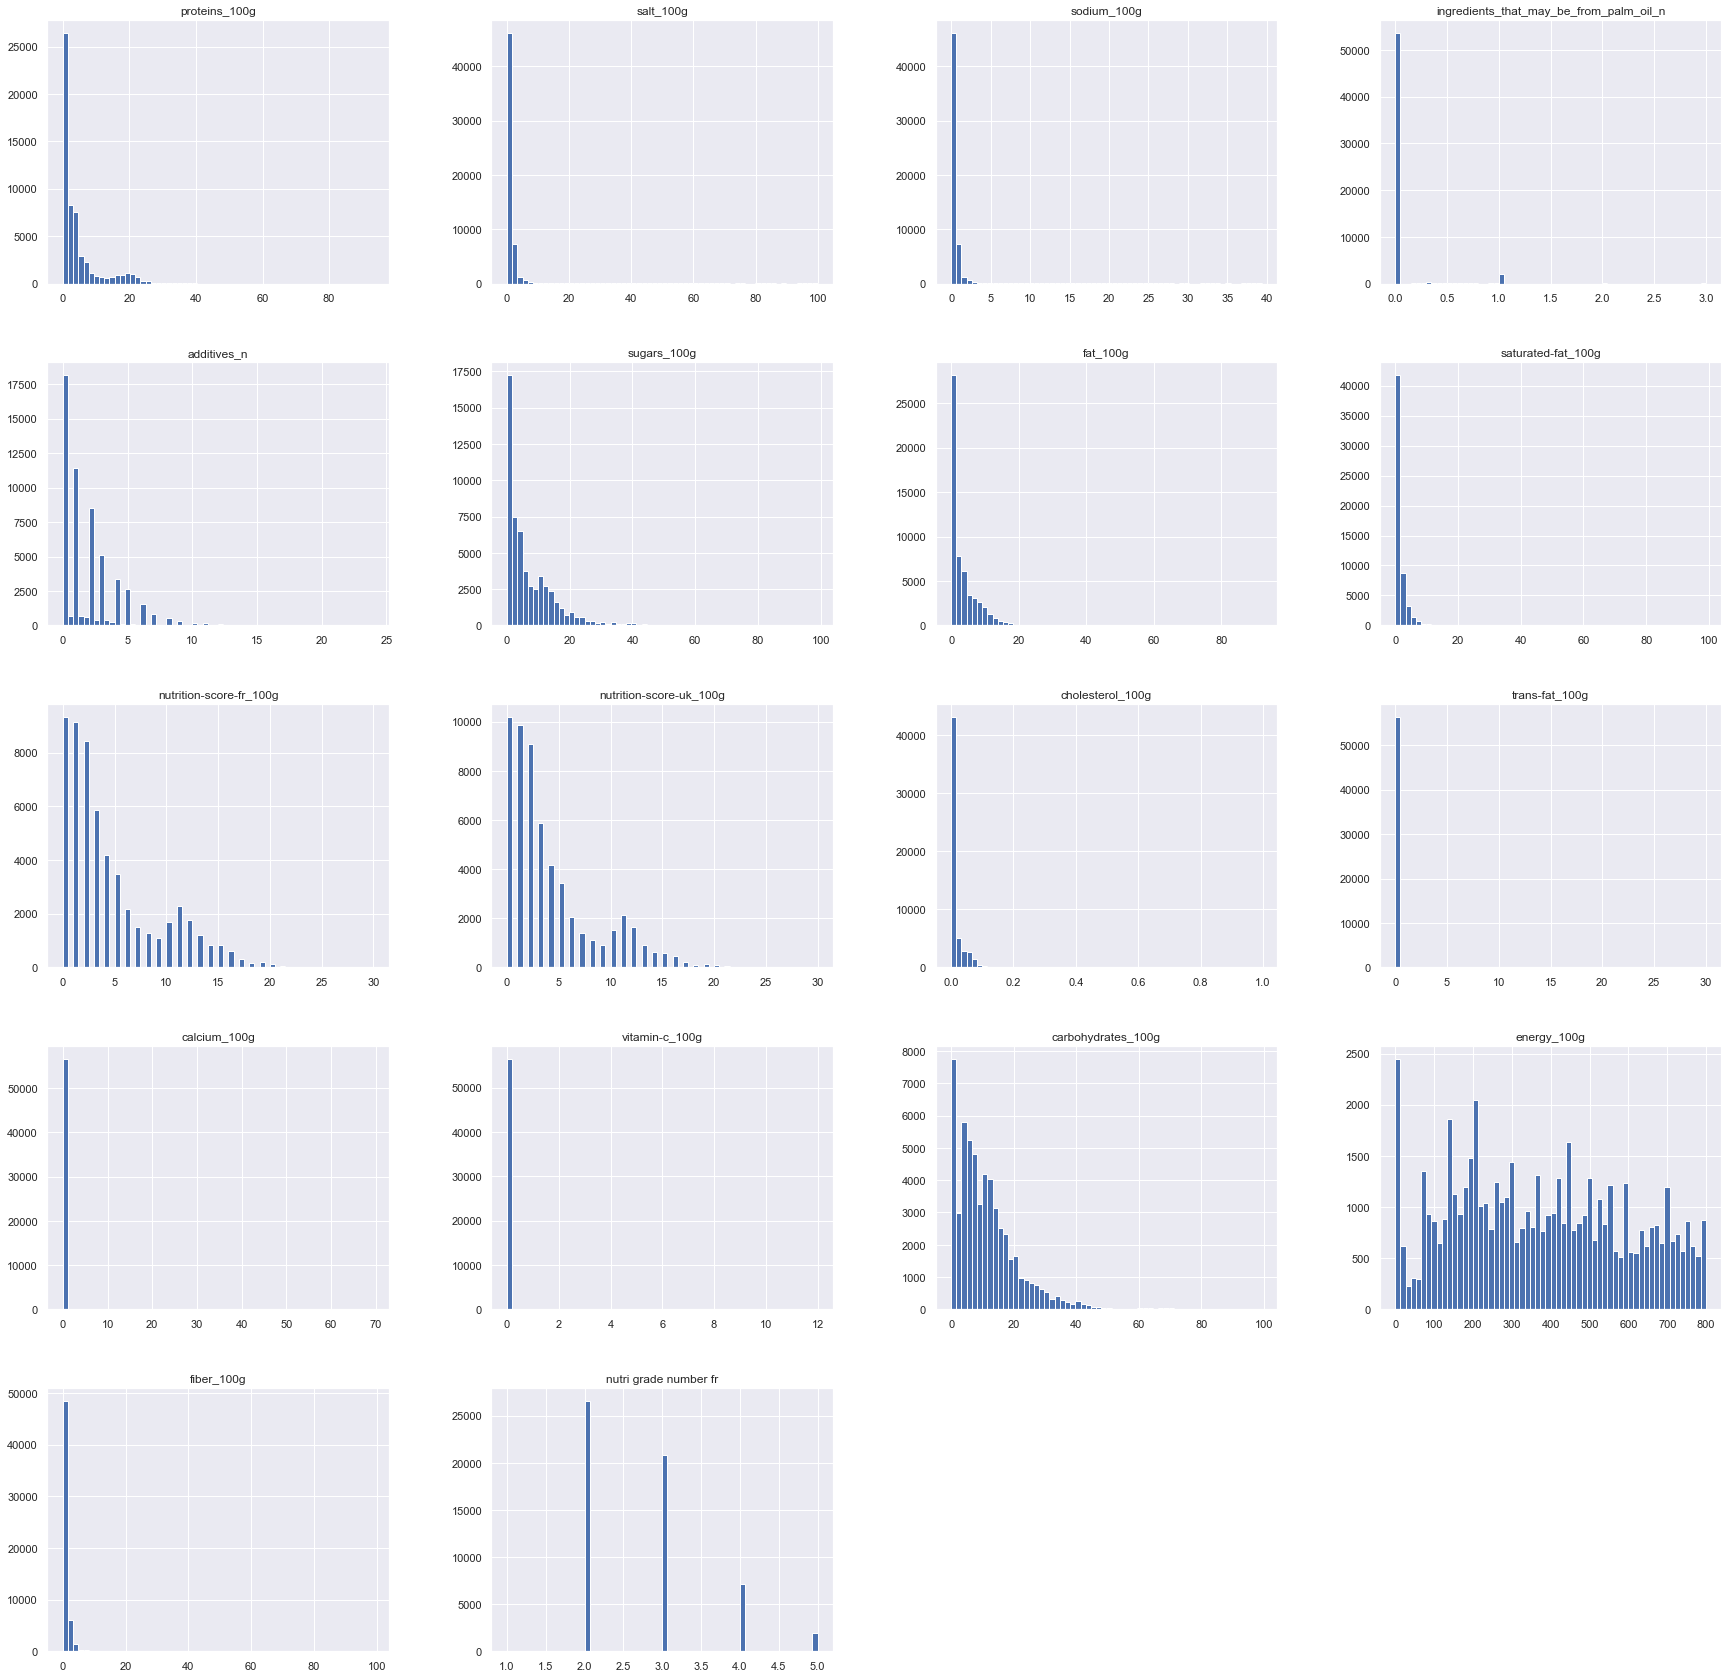

In [109]:
data_KNNI[features ].hist(bins=60, figsize=(30, 30))

In [110]:
data_KNNI

,product_name,countries_tags,brands,energy_100g,proteins_100g,pnns_groups_1,pnns_groups_2,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition_grade_fr,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,fiber_100g,nutri grade number fr
product_name + brands,,,,,,,,,,,,,,,,,,,,,,,,
Quiche Lorraine Kirkland Signature,Quiche Lorraine,en:canada,Kirkland Signature,478.0,5.36,Composite foods,Pizza pies and quiche,0.49900,0.196000,0.0,3.000000,0.714,6.79,2.86,b,2.0,2.0,0.010700,0.000000,0.028600,0.000429,7.860000,0.357,2.0
"Pepsi, Nouveau goût ! Pepsi","Pepsi, Nouveau goût !",en:france,Pepsi,177.0,0.00,Beverages,Sweetened beverages,0.02540,0.010000,0.0,2.000000,10.400,0.00,0.00,e,13.0,2.0,0.000619,0.015453,0.029142,0.013778,10.400000,0.000,5.0
"7Up 7Up,Pepsico",7Up,en:france,"7Up,Pepsico",177.0,0.00,Beverages,Sweetened beverages,0.10000,0.039370,0.0,3.000000,10.400,0.00,0.00,e,13.0,2.0,0.000645,0.016099,0.028878,0.014188,10.400000,0.000,5.0
"Ryan's, Juice Melange, Fuji Pom Blend Ryan Orchards","Ryan's, Juice Melange, Fuji Pom Blend",en:united-states,Ryan Orchards,192.0,0.00,unknown,unknown,0.03810,0.015000,0.0,0.000000,10.420,0.00,0.00,b,2.0,2.0,0.000000,0.000000,0.000000,0.000000,11.670000,0.000,2.0
"Ryan's, Lemonade Ryan Orchards","Ryan's, Lemonade",en:united-states,Ryan Orchards,226.0,0.00,unknown,unknown,0.01016,0.004000,0.0,0.000000,13.330,0.00,0.00,b,2.0,2.0,0.000000,0.000000,0.000000,0.000500,13.330000,0.000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Princes Tuna Chunks In Brine 160G Princes,Princes Tuna Chunks In Brine 160G,en:france,Princes,414.0,23.50,unknown,unknown,1.05000,0.413386,0.0,0.000000,0.000,0.10,0.10,b,0.0,0.0,0.046662,0.000000,0.032539,0.000184,0.100000,0.100,2.0
Santa Cruz Chilli & Lime Dressing Newman's Own,Santa Cruz Chilli & Lime Dressing,en:united-kingdom,Newman's Own,660.0,0.30,Fat and sauces,Dressings and sauces,0.54102,0.213000,0.0,1.000000,16.700,6.90,0.50,c,6.0,6.0,0.055353,0.000000,0.111925,0.000000,23.100000,0.600,3.0
Fiche Brevet Hatier,Fiche Brevet,en:france,Hatier,4.0,10.00,unknown,unknown,10.00000,3.937008,0.0,2.494306,1.000,0.00,1.00,b,0.0,0.0,0.000000,0.000000,0.027995,0.020881,4.131414,10.000,2.0


Les données comblées se basent sur la vraisemblance des données. C'est la données la plus pertinente que nous avons, nous allons partir sur cette données

# Enregistrement de la données

In [111]:
data_KNNI.to_csv("data_KNNI.csv", index=False)
##Plutot CSV

In [112]:
data_ITERATIVE.to_csv("data_ITERATIVE.csv", index=False)

In [113]:
data_MEDIANE.to_csv("data_MEDIANE.csv", index=False)